In [3]:
import pandas as pd
import numpy as np
import plotly.express as px
import pycountry as pc
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

from sklearn import preprocessing

from sklearn.neural_network import MLPRegressor

from ipywidgets import widgets

from IPython.display import display, HTML, clear_output

from fast_autocomplete import AutoComplete

from tqdm.notebook import tqdm

import warnings

# Load and Clean Dataset

In [4]:
df = pd.read_csv("beer_reviews_countries.csv")

In [5]:
dic = {"1930": "USA", "18968": "USA", "1953": "USA", "9343": "USA", "10099": "USA", "3817": "NZL", "1549": "USA", "10097": "USA", "1548": "USA", "5379": "USA", "5318": "USA", "3257": "CAN", "23980": "USA"}
for brew_id, country_code in dic.items():
    country = pc.countries.get(alpha_3 = country_code)
    df.loc[df.brewery_id == int(brew_id), "country_alpha_3"] = country_code
    df.loc[df.brewery_id == int(brew_id), "country_plain"] = country.name

In [6]:
df = df.drop(["Unnamed: 0", "country_numeric", "country_alpha_2"], axis=1)
df = df.dropna()

In [7]:
df[["brewery_id", "beer_beerid"]] = df[["brewery_id", "beer_beerid"]].astype(object)
df["review_time"] = pd.to_datetime(df["review_time"], unit='s')

In [ ]:
df.dtypes

#### Add Mean of Reviews and Number of Reviews per Beer

In [9]:
df['review_mean'] = (df['review_overall'] + df['review_aroma'] + df['review_appearance'] + df['review_palate'] + df['review_taste']) / 5
number_of_beer_reviews = df.beer_beerid.value_counts().rename('review_count')
df = df.merge(number_of_beer_reviews.to_frame(), left_on='beer_beerid', right_index=True)

In [ ]:
df.head()

# Correlation

### Q1: How do the different ratings and the alcohol content correlate?

In [ ]:
df_beer_abv = df.groupby(["beer_abv"]).mean().reset_index()
fig = px.scatter_matrix(df_beer_abv, dimensions=["beer_abv", "review_overall", "review_aroma", "review_appearance", "review_palate", "review_taste"], height=1000)
fig.show()

In [ ]:
df.corr(method='spearman').round(decimals=2)

# ABV

### Q2: What is the mean alcohol content overall?

In [ ]:
df.beer_abv.describe()

### Q3: How does the detailed distribution of the alcohol content look like?

In [ ]:
fig = px.histogram(data_frame=df[df['beer_abv']<20], x="beer_abv", title='How strong is the beer???', nbins=50)
fig.show()

In [ ]:
fig = px.box(df[df['beer_abv']<20], x="beer_abv", orientation="h", title='How strong is the beer??? - as Boxplot')
fig.show()

### Q4: Which countries produce the strongest/weakest beer?

In [19]:
df_country = df.groupby(["country_plain", "country_alpha_3"]).mean().reset_index().round(4)

In [ ]:
df_country.sort_values(by=['beer_abv'], ascending=False).head()

In [ ]:
df_country.sort_values(by=['beer_abv']).head()

#### Map that shows an overview of the mean beer strength for the different countries

In [ ]:
fig = px.choropleth(df_country, locations="country_alpha_3",
                    color="beer_abv",
                    hover_name="country_plain",
                    color_continuous_scale=px.colors.sequential.OrRd,
                   height = 1000)
fig.show()

# Beer Style

### Q5 / Q6: What is the most common beer style? / How many different beer styles are there?

In [ ]:
df.beer_style.describe()

### Q7: What are the best rated beer styles?

In [ ]:
df_beer_style = df.groupby(["beer_style"]).mean().reset_index().round(4)
df_beer_style.shape

In [ ]:
df_beer_style_sorted = df_beer_style.sort_values(by=['review_mean'])
df_beer_style_sorted.sort_values(by=['review_mean'], ascending=False).head()

### Q8: How do the beer styles differ in the individual ratings?

In [ ]:
fig = px.scatter(df_beer_style_sorted, x="beer_style", y="review_mean", height=800)
fig.update_layout(yaxis_title="Rating")
fig.add_scatter(x=df_beer_style_sorted["beer_style"], y=df_beer_style_sorted["review_overall"], name="Overall")
fig.add_scatter(x=df_beer_style_sorted["beer_style"], y=df_beer_style_sorted["review_aroma"], name="Aroma")
fig.add_scatter(x=df_beer_style_sorted["beer_style"], y=df_beer_style_sorted["review_appearance"], name="Appearance")
fig.add_scatter(x=df_beer_style_sorted["beer_style"], y=df_beer_style_sorted["review_palate"], name="Palate")
fig.add_scatter(x=df_beer_style_sorted["beer_style"], y=df_beer_style_sorted["review_taste"], name="Taste")
fig.show()

# Brewery

### Q9: Which breweries (>500 ratings) produce the best beer?

In [ ]:
df_brewery = df.groupby(["brewery_name", "country_plain"]).mean().reset_index().round(2)
df_brewery = df_brewery[df_brewery["review_count"]>500].sort_values(by=['review_mean'])
df_brewery.sort_values(by = "review_mean", ascending=False).head()

In [ ]:
fig = px.scatter(df_brewery, x="brewery_name", y="review_mean", color="beer_abv", size="beer_abv", height=800)
fig.show()

### Q10: What are the best breweries in each country?

In [ ]:
df_brewery_by_country = df.groupby(["brewery_name", "country_plain"]).mean().reset_index().round(2)
df_brewery_by_country = df_brewery_by_country[df_brewery_by_country["review_count"]>10].sort_values(by=['review_mean'], ascending=False)
df_brewery_only_best = df_brewery_by_country.groupby(["country_plain"]).head(1).reset_index(drop=True)
df_brewery_only_best.head()

In [ ]:
fig = px.scatter(df_brewery_only_best.sort_values(by="review_mean"), x="brewery_name", y="review_mean", color="country_plain", height=800)
fig.show()

# Beer

### Q11: What are the best beers overall?

In [ ]:
df_beer_name = df
df_beer_name["brewery_and_beer"] = df["brewery_name"] + ": " + df["beer_name"]
df_beer_name = df_beer_name[df_beer_name["review_count"]>20].groupby(["brewery_and_beer", "country_plain"]).mean().reset_index().round(4).sort_values(by=['review_mean'])
df_beer_name.sort_values(by=['review_mean'], ascending=False).head()

In [ ]:
df_beer_name.shape

### Q12: How to the indivitual ratings change with the overall rating increasing?

In [ ]:
fig = px.scatter(df_beer_name, x="brewery_and_beer", y="review_mean", height=800)
fig.update_layout(yaxis_title="Rating")
fig.add_scatter(x=df_beer_name["brewery_and_beer"], y=df_beer_name["review_overall"], name="Overall")
fig.add_scatter(x=df_beer_name["brewery_and_beer"], y=df_beer_name["review_aroma"], name="Aroma")
fig.add_scatter(x=df_beer_name["brewery_and_beer"], y=df_beer_name["review_appearance"], name="Appearance")
fig.add_scatter(x=df_beer_name["brewery_and_beer"], y=df_beer_name["review_palate"], name="Palate")
fig.add_scatter(x=df_beer_name["brewery_and_beer"], y=df_beer_name["review_taste"], name="Taste")
fig.show()

### Q13: What is the best beer in each country?

In [ ]:
df_beer_by_country = df.groupby(["beer_name", "country_plain"]).mean().reset_index().round(2)
df_beer_by_country = df_beer_by_country[df_beer_by_country["review_count"]>10].sort_values(by=['review_mean'], ascending=False)
df_beer_by_country = df_beer_by_country.groupby(["country_plain"]).head(1).reset_index(drop=True)
df_beer_by_country.head()

In [ ]:
fig = px.scatter(df_beer_by_country.sort_values(by="review_mean"), x="beer_name", y="review_mean", color="country_plain", height=800)
fig.show()

### Q14: What is the best/worst famous (> 1000 ratings) beer?

In [ ]:
df_with_counts = df
df_with_counts["brewery_and_beer"] = df_with_counts["brewery_name"] + ": " + df_with_counts["beer_name"]
df_beer_name_with_count = df_with_counts[df_with_counts['review_count']>1000].groupby(["brewery_and_beer", "country_plain"]).mean().reset_index().round(4)
df_beer_name_with_count.shape

In [ ]:
df_beer_name_with_count.sort_values(by=['review_mean'], ascending=False).head()

In [ ]:
df_beer_name_with_count.sort_values(by=['review_mean']).head()

In [ ]:
fig = px.scatter(df_beer_name_with_count.sort_values(by=['review_mean']), x="brewery_and_beer", y="review_mean", color="beer_abv", height=500)
fig.show()

# Country

### Q15: Which countries produce the best beer?

In [ ]:
df_country = df[df['review_count']>50].groupby(["country_plain"]).mean().reset_index().round(4)
df_country.sort_values(by=['review_mean'], ascending=False).head()

#### Overview of top countries by review mean

In [ ]:
fig = px.scatter(df_country.sort_values(by=['review_mean']), x="country_plain", y="review_mean", color="review_mean")
fig.show()

In [ ]:
df_country_rating = df[df['review_count']>50].groupby(["country_plain", "country_alpha_3"]).mean().reset_index()
fig = px.choropleth(df_country_rating, locations="country_alpha_3",
                    color="review_mean", # lifeExp is a column of gapminder
                    hover_name="country_plain", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma,
                   height=1000)
fig.show()

## Austria

### Q16: What are the best/worst beers in Austria?

In [ ]:
df_austria = df
df_austria["brewery_and_beer"] = df["brewery_name"] + ": " + df["beer_name"]
df_austria_grouped = df_austria[(df_austria['country_plain']=="Austria") & (df_austria['review_count']>5)].groupby(["beer_name", "brewery_name"]).mean().reset_index().round(4)
df_austria_grouped.sort_values(by=['review_mean'], ascending=False).head()

In [ ]:
df_austria_grouped.sort_values(by=['review_mean']).head()

#### Austria beer overview by mean rating

In [ ]:
fig = px.scatter(df_austria[(df_austria['country_plain']=="Austria") & (df_austria['review_count']>5)].groupby("brewery_and_beer").mean().reset_index().round(4).sort_values(by=['review_mean']), x="brewery_and_beer", y="review_mean", color="review_mean", height=500)
fig.show()

### Q17: What are the most famous beer in Austria (by number of ratings)?

In [ ]:
df_austria_grouped.sort_values(by=['review_count'], ascending=False).head()

# Machine Learning

In [ ]:
df.head() 

In [298]:
df_ml = df.drop(["review_count", "brewery_name","review_profilename", "review_time", "beer_name", "country_plain", "review_overall", "review_aroma", "review_appearance", "review_palate", "review_taste", "brewery_id", "beer_beerid"], axis=1)

In [299]:
categorical_columns = ["beer_style", "country_alpha_3"]

In [300]:
for col in categorical_columns:
    df_ml[col] = df_ml[col].astype('category')

In [ ]:
df_ml.head()

In [302]:
df_ml.dtypes

beer_style         category
beer_abv            float64
country_alpha_3    category
review_mean         float64
dtype: object

In [303]:
df_ml = pd.get_dummies(df_ml, drop_first=True)

In [304]:
df_ml.head()

,beer_abv,review_mean,beer_style_American Adjunct Lager,beer_style_American Amber / Red Ale,beer_style_American Amber / Red Lager,beer_style_American Barleywine,beer_style_American Black Ale,beer_style_American Blonde Ale,beer_style_American Brown Ale,beer_style_American Dark Wheat Ale,...,country_alpha_3_USA,country_alpha_3_UZB,country_alpha_3_VCT,country_alpha_3_VEN,country_alpha_3_VIR,country_alpha_3_VNM,country_alpha_3_VUT,country_alpha_3_WSM,country_alpha_3_ZAF,country_alpha_3_ZWE
0,5.0,1.8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6.2,2.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6.5,2.9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5.0,3.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7.7,4.2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [383]:
df_ml = df_ml.groupby(["beer_abv"]).mean().reset_index()
y = df_ml[df_ml['beer_abv']<10].review_mean
X = df_ml[df_ml['beer_abv']<10].drop(["review_mean"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

#X_train = preprocessing.scale(X_train)
#X_test = preprocessing.scale(X_test)
#y_train = preprocessing.scale(y_train)
#y_test = preprocessing.scale(y_test)

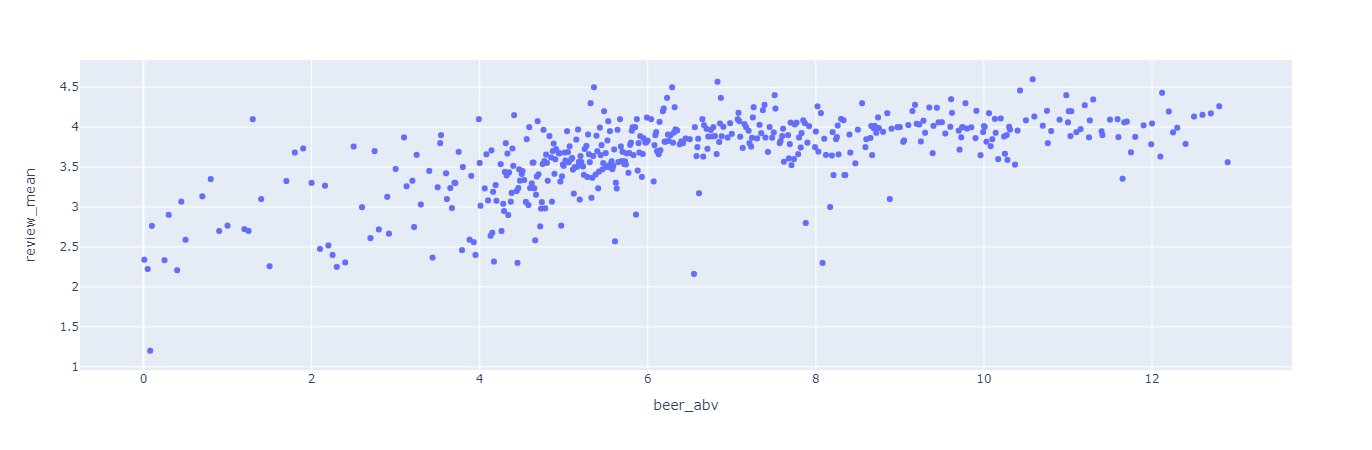

In [367]:
fig = px.scatter(df_ml[df_ml['beer_abv']<13], x="beer_abv", y="review_mean", height=800)
fig.show()

In [384]:
reg = LinearRegression().fit(X_train, y_train)
reg.score(X_train, y_train)

0.8167743326148521

In [391]:
mlp = MLPRegressor(hidden_layer_sizes=(128, 256, 256,), activation='relu', solver='adam', alpha=0.02, batch_size=200,
                   learning_rate='constant', learning_rate_init=0.01, power_t=0.5, max_iter=1000, shuffle=True,
                   random_state=10, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True,
                   early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                   epsilon=1e-08, n_iter_no_change=10, max_fun=15000).fit(X_train, y_train)

pred_train_mlp = mlp.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_mlp)))
print(r2_score(y_train, pred_train_mlp))

pred_test_mlp = mlp.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_mlp))) 
print(r2_score(y_test, pred_test_mlp))

#fig = px.scatter(x=df_ml[df_ml['beer_abv']<20].beer_abv, y=pred_train_mlp, height=800)
#fig.show()


0.28116901422152896
0.684578361149765
0.3927831786428722
0.3137881703834138


In [280]:
# dtree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=0.13, random_state=3)
dtree.fit(X_train, y_train)
pred_train_tree= dtree.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_tree)))
print(r2_score(y_train, pred_train_tree))

pred_test_tree= dtree.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_tree))) 
print(r2_score(y_test, pred_test_tree))

0.7466306225552394
0.4425427134627756
0.7037628891364966
0.5047177958742514


In [385]:
model_rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)
model_rf.fit(X_train, y_train) 
pred_train_rf= model_rf.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train_rf)))
print(r2_score(y_train, pred_train_rf))

pred_test_rf = model_rf.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred_test_rf)))
print(r2_score(y_test, pred_test_rf))

0.14265131835419445
0.9188089520983078
0.32622266058114624
0.5266518429248781


In [388]:
df_test = pd.DataFrame(data=X_test)
df_train = pd.DataFrame(data=X_train)

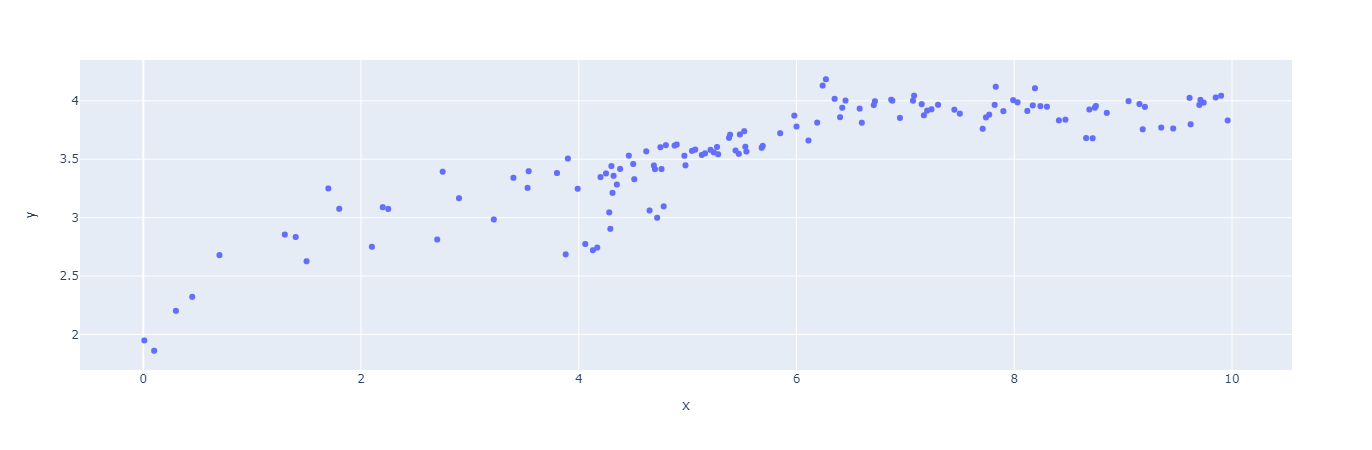

In [390]:
fig = px.scatter(x=df_test["beer_abv"], y=pred_test_rf, height=800)
fig.show()

# Recommender System

Adapted from: https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d

In [9]:
df_recommender = df[df.review_count>100]

In [10]:
warnings.filterwarnings('ignore')

In [11]:
beer_matrix = df_recommender.pivot_table(index='review_profilename', columns='beer_beerid', values='review_mean')
beer_matrix.head()

beer_beerid,5,6,7,9,10,14,15,17,19,23,...,74323,74390,74491,74530,74548,74579,74904,74986,75013,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02maxima,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
03SVTCobra,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
ratings = pd.DataFrame(df_recommender.groupby('beer_beerid').mean())
ratings.head()

,review_overall,review_aroma,review_appearance,review_palate,review_taste,beer_abv,review_mean,review_count
beer_beerid,,,,,,,,
5,3.549528,3.205189,3.485849,3.318396,3.340802,4.5,3.379953,424
6,3.706956,3.515964,3.836374,3.513113,3.645382,5.6,3.643558,877
7,3.266313,3.179059,3.251138,3.106980,3.101669,4.2,3.181032,659
9,3.400862,2.853448,3.051724,3.103448,3.043103,4.2,3.090517,116
10,3.826117,3.747207,3.936453,3.742318,3.767458,7.0,3.803911,716


In [13]:
words = {}

def get_words():
    unique_beer_names = df_recommender.beer_name.unique()
    for beer_name in unique_beer_names:
        words[beer_name] = {}

get_words()

autocomplete = AutoComplete(words=words)

In [14]:
outs = []

def lookup_beer(beer_name):
    if (len(outs) > 0):
        for out in outs:
            out.clear_output()
    out_lookup = widgets.Output()
    basis_beer = df_recommender[df_recommender.beer_name.str.lower() == beer_name.lower()]
    basis_beer_id = basis_beer.beer_beerid.iloc[0]
    
    user_rating = beer_matrix[basis_beer_id]
    # user_rating.head()
    
    similar_to_beer=beer_matrix.corrwith(user_rating)
    # similar_to_beer.head()
    
    corr = pd.DataFrame(similar_to_beer, columns=['Correlation'])
    corr.dropna(inplace=True)
    # corr.head()
    
    corr = corr.join(ratings['review_count'])
    # corr.sort_values(by='Correlation', ascending=False).head(10)
    
    basis_beer = df_recommender[df_recommender.beer_beerid == basis_beer_id]

    recommended_beer_id = corr.sort_values(by='Correlation', ascending=False).index.values[1]
    recommended_beer = df_recommender[df_recommender.beer_beerid == recommended_beer_id]
    #basis_beer = df[df.beer_beerid == corr_2093.iloc[1]]
    with out_lookup:
        display(HTML("<p>You might like " + str(recommended_beer.beer_name.iloc[0]) + ".  Cheers!!</p>"))
        brewery_id = str(recommended_beer.brewery_id.iloc[0])
        link = "https://www.beeradvocate.com/beer/profile/" + brewery_id + "/" + str(recommended_beer_id)
        display(HTML('<a href = "' + link + '" target="_blank">' + recommended_beer.beer_name.iloc[0] + '</a> (on beeradvocate.com)'))
    display(out_lookup)
    outs.append(out_lookup)

    

In [15]:
# TODO: This only works in Notebook but not in JupyterLab Yet..
out = widgets.Output()

n_of_suggestions = widgets.IntSlider(
    value=7,
    min=1,
    max=50,
    step=1,
    description='#Suggestions:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

suggestions = ["" for i in range(n_of_suggestions.value)]

def sort(change): 
    if change['type'] == 'change' and change['name'] == 'value':
        sorted_ratings = ratings.sort_values(suggestion_criterion.value, ascending=False)
        
        suggestions = ["" for i in range(n_of_suggestions.value)]
        
        for i in tqdm(range(n_of_suggestions.value)):
            suggested_beer_id = sorted_ratings.index.values[i]
            suggested_beer = df_recommender[df_recommender.beer_beerid == suggested_beer_id]
            suggestions[i] = suggested_beer.beer_name.iloc[0]
        
        suggestion.options = suggestions
        
suggestion_criterion = widgets.Dropdown(
    options=["review_overall", "review_aroma", "review_appearance", "review_palate", "review_taste", "beer_abv", "review_mean", "review_count"],
    value='review_count',
    description='Sort by:',
    disabled=False,
)


suggestion_criterion.observe(sort)

# --------------------------------------------------------------------------------------

display(HTML("<h1>Beer Machine</h1>"))
display(HTML("<p>Type in the name of the beer you are currently enjoying and our system will recommend you a new one.</p>"))
basis_beer_name = widgets.Text(placeholder='90 Minute IPA',
    description='Beer name:')

autocomplete_beer_name = widgets.Text(placeholder='Magic',
    description='Auto:')


def complete(change):
    if change['type'] == 'change' and change['name'] == 'value':
        search = autocomplete.search(word=basis_beer_name.value, max_cost=3, size=3)
        if (len(search) > 0 and len(search[0]) > 0):
            autocomplete_beer_name.value = search[0][0]

basis_beer_name.observe(complete)

display(basis_beer_name)
display(autocomplete_beer_name)

button_manual = widgets.Button(
    description='Search',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to get a beer recommendation',
    icon='beer' # (FontAwesome names without the `fa-` prefix)
)

display(button_manual)

def handle_submit(sender):
    out = widgets.Output()
    if (len(autocomplete_beer_name.value) == 0):
        print("Type in the name of a beer first!")
        return
    with out:
        display(HTML("<p>Looking for a recommendation based on the beer: " + autocomplete_beer_name.value + "</p>"))
        display(HTML('<img src="https://media.giphy.com/media/luSZvotp8VSGA/giphy.gif" alt="this slowpoke moves"  width=250/>'))
    display(out)
    lookup_beer(autocomplete_beer_name.value)
    out.clear_output()
    
button_manual.on_click(handle_submit)

display(HTML("<p></br>Alternatively you can give one of the suggested beers a try.</p>"))

suggestion = widgets.Dropdown(
    options=suggestions,
    value=suggestions[0],
    description='Suggested:',
    disabled=False,
)
display(n_of_suggestions)
display(suggestion_criterion)
display(suggestion)

button_suggested = widgets.Button(
    description='Search',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me to get a beer recommendation',
    icon='beer' # (FontAwesome names without the `fa-` prefix)
)

display(button_suggested)

def handle_submit_suggested(sender):
    out = widgets.Output()
    with out:
        display(HTML("<p>Looking for a recommendation based on the beer: " + suggestion.value + "</p>"))
        display(HTML('<img src="https://media.giphy.com/media/luSZvotp8VSGA/giphy.gif" alt="this slowpoke moves"  width=250/>'))
    display(out)
    lookup_beer(suggestion.value)
    out.clear_output()
    
button_suggested.on_click(handle_submit_suggested)

Text(value='', description='Beer name:', placeholder='90 Minute IPA')

Text(value='', description='Auto:', placeholder='Magic')

Button(description='Search', icon='beer', style=ButtonStyle(), tooltip='Click me to get a beer recommendation'…

IntSlider(value=7, continuous_update=False, description='#Suggestions:', max=50, min=1)

Dropdown(description='Sort by:', index=7, options=('review_overall', 'review_aroma', 'review_appearance', 'rev…

Dropdown(description='Suggested:', options=('', '', '', '', '', '', ''), value='')

Button(description='Search', icon='beer', style=ButtonStyle(), tooltip='Click me to get a beer recommendation'…

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()